In [ ]:
!pip install -q pandas matplotlib
!pip install -q statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL # Import STL from the correct submodule
from statsmodels.tsa.stattools import adfuller # Import adfuller from the correct submodule

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Helper

In [ ]:
def seasonal_decompose(label, grouped, date, value, period):
  # Select a specific label
  label_to_analyze = label
  data = grouped.get_group(label_to_analyze)
  # print(data.head())

  # Convert 'Date-Time' to datetime and set as index
  data.loc[:, date] = pd.to_datetime(data[date]) # Use .loc to modify the DataFrame
  data = data.set_index(date)

  if not pd.api.types.is_numeric_dtype(data[value]):
    data[value] = data[value].str.replace(',', '').astype(float)

  # Perform seasonal decomposition using statsmodels STL
  stl = STL(data[value], period=period)  # Adjust period as needed
  result = stl.fit()

  # Extract components
  trend = result.trend
  seasonal = result.seasonal
  resid = result.resid

  # print(trend)
  # print(seasonal)
  # print(resid)

  # Check for and handle infinite or NaN values in residuals
  resid = resid.replace([np.inf, -np.inf], np.nan).dropna() # Replace infinite values with NaN and then forward fill

  # Plot the results
  plt.figure(figsize=(14, 8))

  plt.subplot(4, 1, 1)
  plt.plot(data.index, data[value], label='Original')
  plt.title('Seasonal Decomposition')
  plt.ylabel('Closing Value')
  plt.grid(True)

  plt.subplot(4, 1, 2)
  plt.plot(data.index, trend, label='Trend', color='orange')
  plt.ylabel('Trend')
  plt.grid(True)

  plt.subplot(4, 1, 3)
  plt.plot(data.index, seasonal, label='Seasonal', color='green')
  plt.ylabel('Seasonal')
  plt.grid(True)

  plt.subplot(4, 1, 4)
  plt.plot(data.index, resid, label='Residual', color='red')
  plt.ylabel('Residual')
  plt.xlabel('Date')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

  # Perform ADF test
  adf_result = adfuller(resid)
  adf_statistic = adf_result[0]
  p_value = adf_result[1]
  critical_values = adf_result[4]

  if p_value < 0.05:
    print(f'{label} is stationary with p-value: {p_value}')

## Hypothesis: Preprocessed Food (Broiler Meat and Sugar) cause obesity and we expect to see these changes reflected in the stocks.

# Meat Data

## Meat Production

In [ ]:
meat_path = "/content/drive/MyDrive/Research @ CMU/Citadel Datathon/Datathon Data/Meat_Stats_Meat_Production.csv"
# Reading the file
with open(meat_path, 'r') as file:
    content = file.read()

In [ ]:
meat_df = pd.read_csv(meat_path, parse_dates=['Date'], date_format='%b-%Y') # Use '%d' for day

In [ ]:
production_df = meat_df[((meat_df['Animal'] == 'Pork') | (meat_df['Animal'] == 'Beef') | (meat_df['Animal'] == 'Broilers')) & (meat_df['Date'] >= '1983-01-01')]

In [ ]:
grouped = production_df.groupby('Animal')

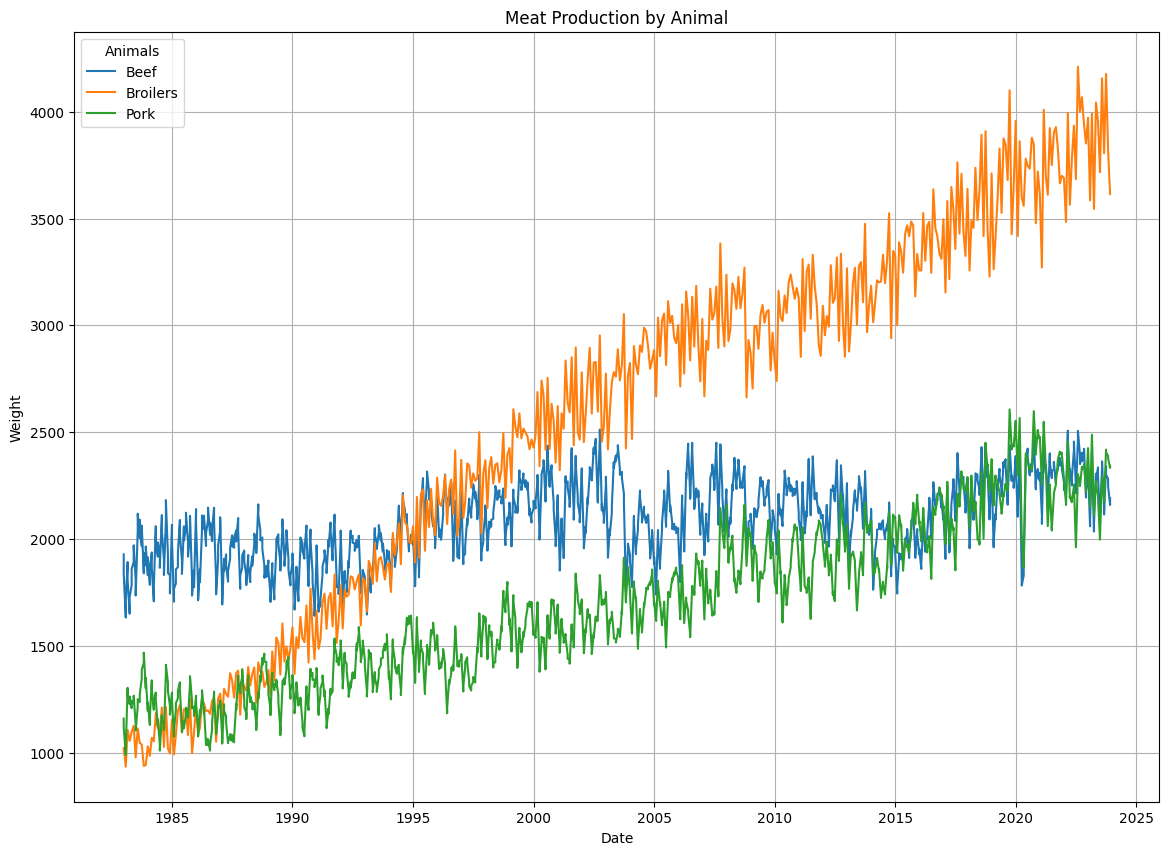

In [ ]:
import matplotlib.pyplot as plt

# Create a plot for each label
plt.figure(figsize=(14, 10))

for label, group in grouped:
    group = group.sort_values(by='Date')  # Sort by 'Date'
    group['Production'] = group['Production'].str.replace(',', '').astype(float)  # Remove commas and convert to float
    plt.plot(group['Date'], group['Production'], label=label)

plt.title('Meat Production by Animal')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(title='Animals')
plt.grid(True)
plt.show()

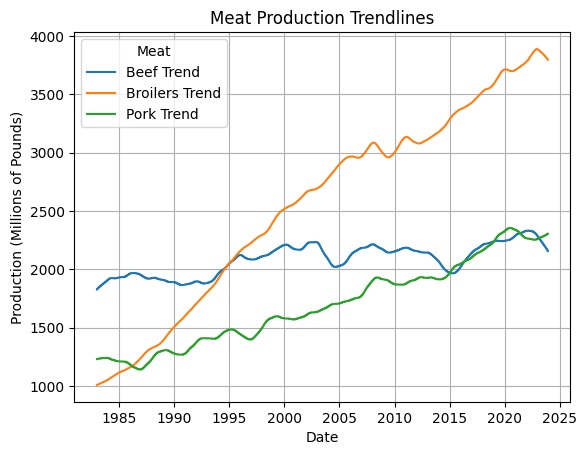

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Sample data setup (replace this with your actual data)
# grouped = {label: pd.DataFrame(data)} # Replace with actual grouping

# Customize the seasonal period as needed for each group
seasonal_periods = {'Broilers': 13, 'Beef': 27, 'Pork': 27}  # Replace with actual periods for each group

for label, group in grouped:
    # print(f"Processing group: {label}")  # Debugging line

    # # Check column names and DataFrame structure
    # print(group.columns)
    # print(group.head())

    # Ensure 'Date' column exists and is correctly named
    if 'Date' not in group.columns or 'Production' not in group.columns:
        print(f"Skipping group {label} due to missing columns")
        continue

    group = group.sort_values(by='Date')  # Sort by 'Date'
    group['Production'] = group['Production'].str.replace(',', '').astype(float)  # Remove commas and convert to float

    # Set the seasonal period based on the label
    seasonal_period = seasonal_periods.get(label, 13)  # Default to 12 if not specified

    # STL Decomposition
    stl = STL(group['Production'], period=seasonal_period)
    result = stl.fit()

    # Plotting the trend component
    plt.plot(group['Date'], result.trend, label=f'{label} Trend')

plt.title('Meat Production Trendlines')
plt.xlabel('Date')
plt.ylabel('Production (Millions of Pounds)')
plt.legend(title='Meat')
plt.grid(True)
plt.show()

In [ ]:
# seasonal_decompose('Broilers', grouped, 'Date', 'Production', 13)

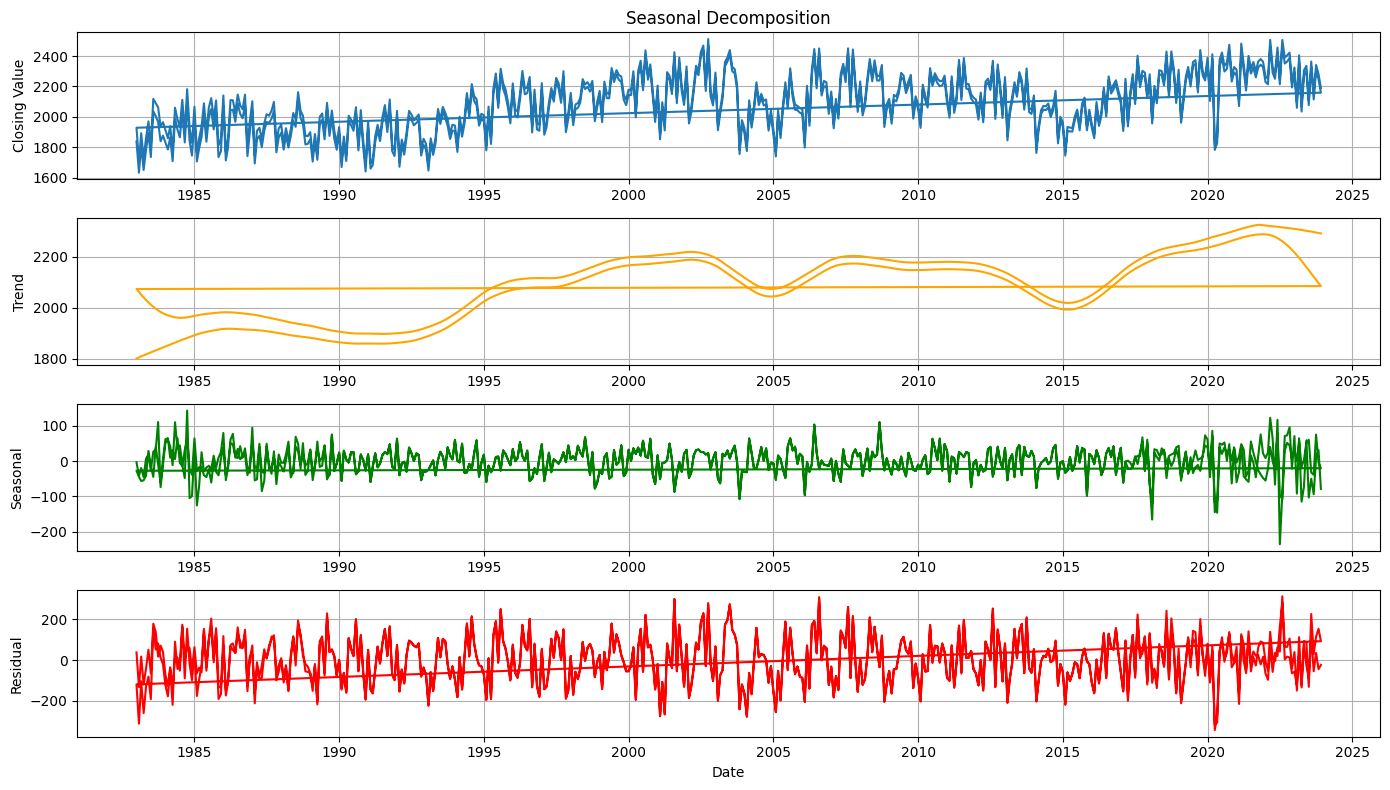

Beef is stationary with p-value: 2.3479346163958016e-10


In [ ]:
seasonal_decompose('Beef', grouped, 'Date', 'Production', 27)

In [ ]:
# seasonal_decompose('Pork', grouped, 'Date', 'Production', 27)

## Cold Storage

In [ ]:
storage_path = "/content/drive/MyDrive/Research @ CMU/Citadel Datathon/Datathon Data/Meat_Stats_Cold_Storage.csv"
# Reading the file
with open(storage_path, 'r') as file:
    content = file.read()

In [ ]:
storage_df = pd.read_csv(storage_path, parse_dates=['Date'], date_format='%b-%Y') # Use date_format instead of date_parser
# storage_df = storage_df[((storage_df['Animal'] == 'Pork') | (storage_df['Animal'] == 'Beef') | (storage_df['Animal'] == 'Broiler') | (storage_df['Animal'] == 'Turkey')) & (storage_df['Date'] >= '2004-01-01')]
storage_df = storage_df[((storage_df['Animal'] == 'Pork') | (storage_df['Animal'] == 'Beef') | (storage_df['Animal'] == 'Broiler')) & (storage_df['Date'] >= '2004-01-01')]
storage_df.sort_values(by='Date', inplace=True)

In [ ]:
grouped = storage_df.groupby('Animal')

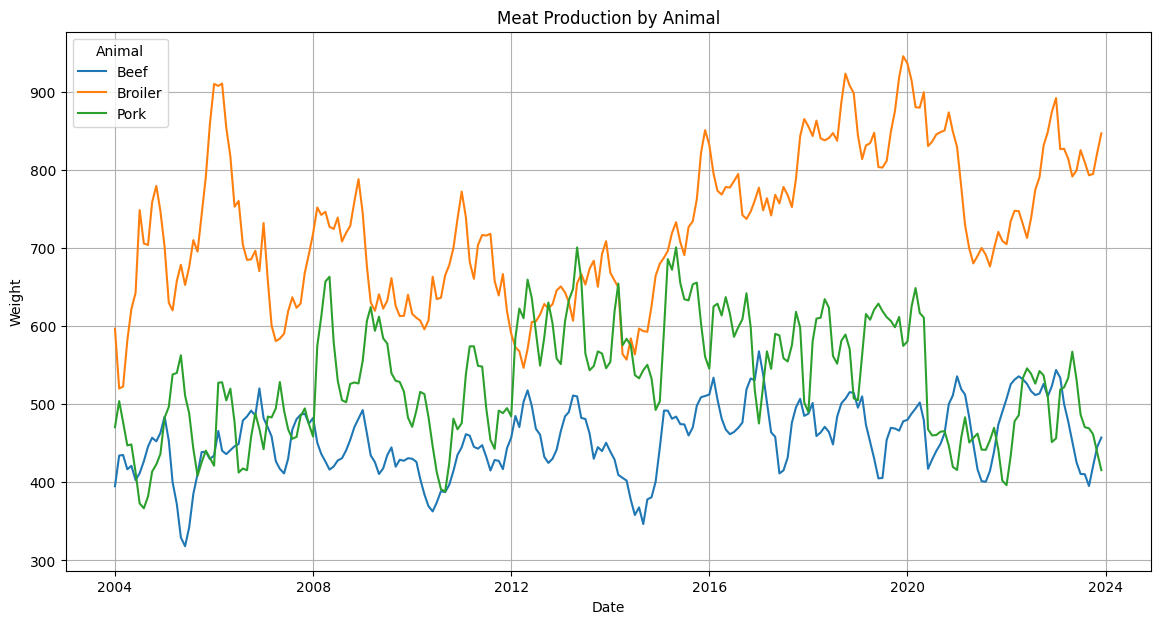

In [ ]:
import matplotlib.pyplot as plt

# Create a plot for each label
plt.figure(figsize=(14, 7))

for label, group in grouped:
    plt.plot(group['Date'], group['Weight'], label=label)

plt.title('Meat Production by Animal')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(title='Animal')
plt.grid(True)
plt.show()

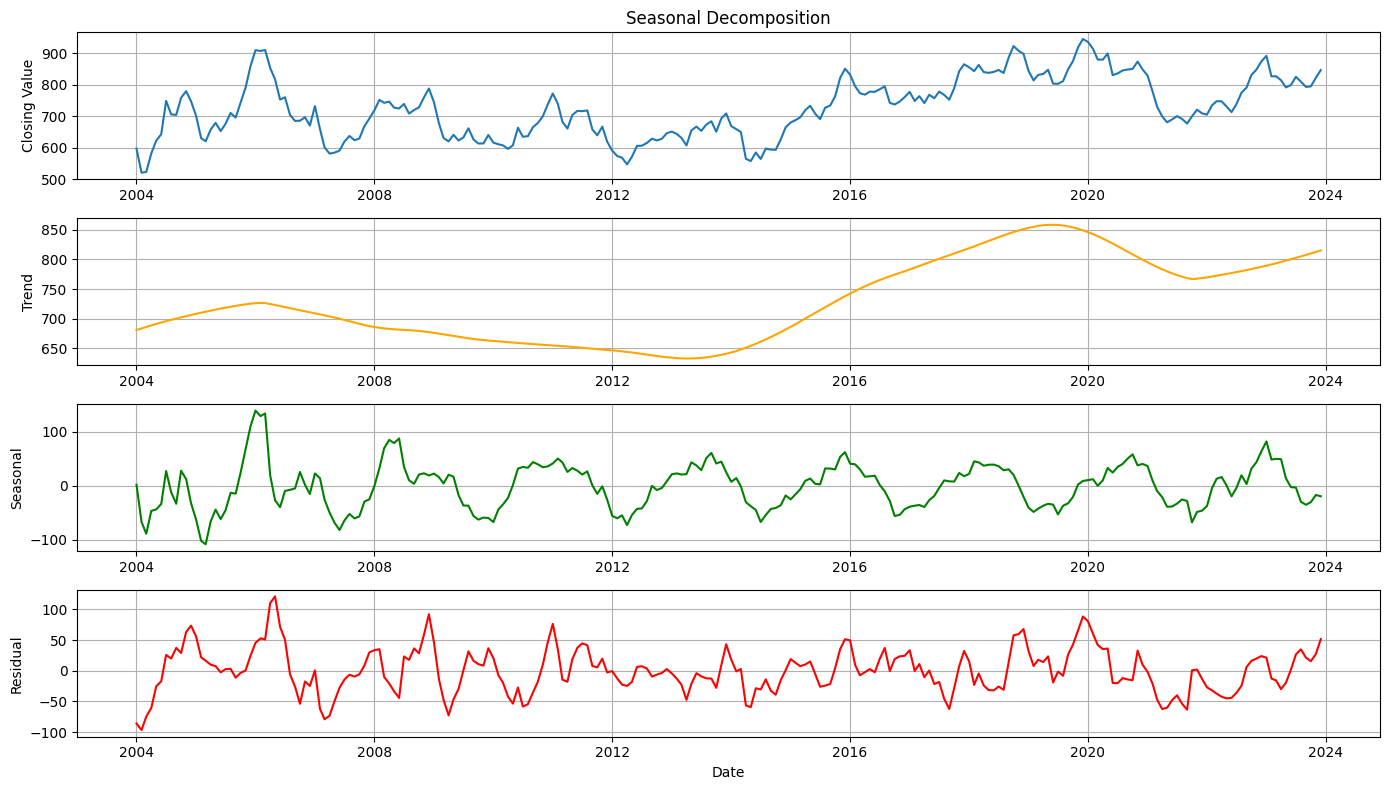

Broiler is stationary with p-value: 4.844213820986379e-10


In [ ]:
seasonal_decompose('Broiler', grouped, 'Date', 'Weight', 27)

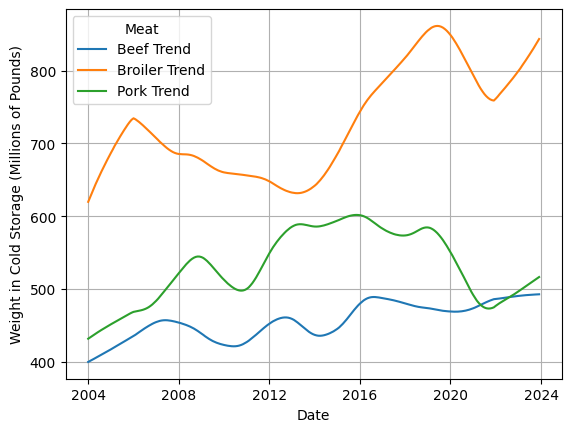

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Sample data setup (replace this with your actual data)
# grouped = {label: pd.DataFrame(data)} # Replace with actual grouping

# Customize the seasonal period as needed for each group
seasonal_periods = {'Broiler': 25, 'Beef': 25, 'Pork': 25}  # Replace with actual periods for each group

for label, group in grouped:
    # print(f"Processing group: {label}")  # Debugging line

    # # Check column names and DataFrame structure
    # print(group.columns)
    # print(group.head())

    # Ensure 'Date' column exists and is correctly named
    if 'Date' not in group.columns or 'Weight' not in group.columns:
        print(f"Skipping group {label} due to missing columns")
        continue

    group = group.sort_values(by='Date')  # Sort by 'Date'
    group['Weight'] = group['Weight'] # Remove commas and convert to float

    # Set the seasonal period based on the label
    seasonal_period = seasonal_periods.get(label, 13)  # Default to 12 if not specified

    # STL Decomposition
    stl = STL(group['Weight'], period=seasonal_period)
    result = stl.fit()

    # Plotting the trend component
    plt.plot(group['Date'], result.trend, label=f'{label} Trend')

plt.xlabel('Date')
plt.ylabel('Weight in Cold Storage (Millions of Pounds)')
plt.legend(title='Meat')
plt.grid(True)
plt.show()

In [ ]:
# seasonal_decompose('Beef', grouped, 'Date', 'Weight', 13)

In [ ]:
# seasonal_decompose('Pork', grouped, 'Date', 'Weight', 13)

In [ ]:
# seasonal_decompose('Turkey', grouped, 'Date', 'Weight', 13)

# Commodity Data

In [ ]:
commodity_path = "/content/drive/MyDrive/Research @ CMU/Citadel Datathon/Datathon Data/all_commodities.csv"
# Reading the file
with open(commodity_path, 'r') as file:
    content = file.read()

In [ ]:
commodity_df = pd.read_csv(commodity_path, parse_dates=['Date-Time'])

In [ ]:
commodity_df['Commodity'].fillna('Corn', inplace=True)
grouped = commodity_df.groupby('Commodity')

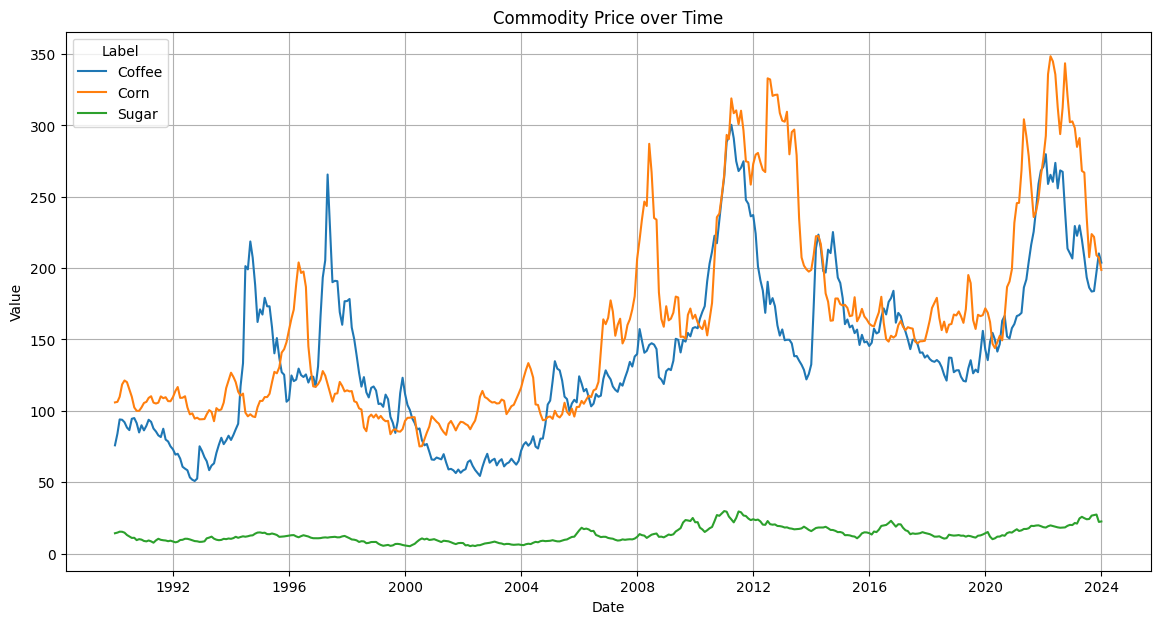

In [ ]:
import matplotlib.pyplot as plt

# Create a plot for each label
plt.figure(figsize=(14, 7))

for label, group in grouped:
    plt.plot(group['Date-Time'], group['Value'], label=label)

plt.title('Commodity Price over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Label')
plt.grid(True)
plt.show()

## Sugar Data

In [ ]:
commodity_path_df = commodity_df[commodity_df['Commodity'] == 'Sugar']

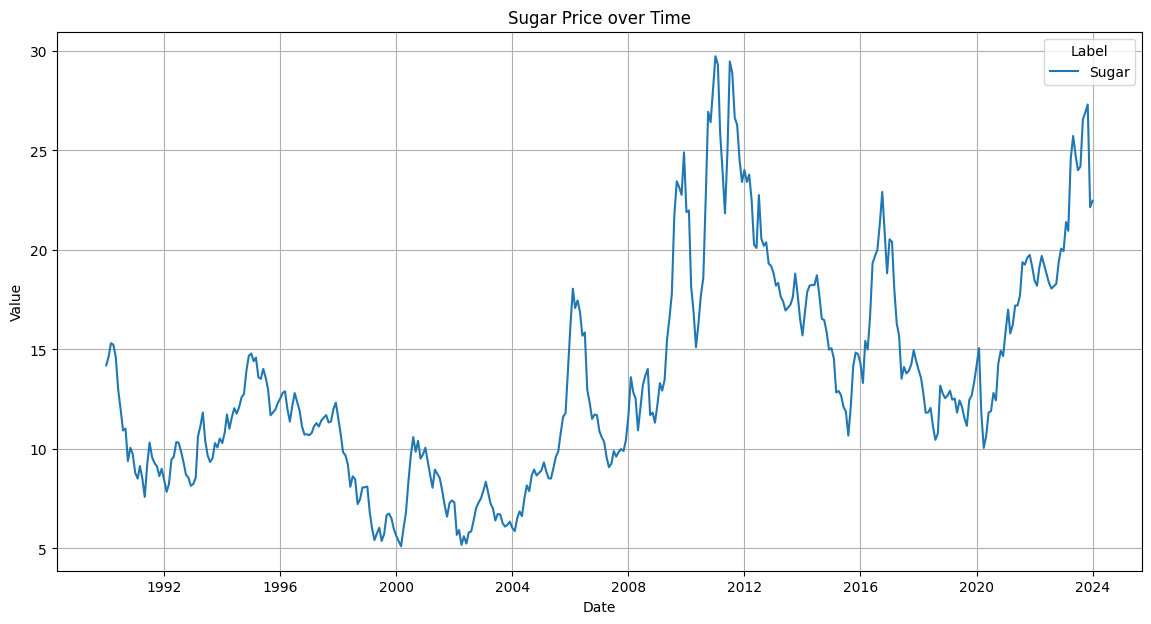

In [ ]:

import matplotlib.pyplot as plt

# Create a plot for each label
plt.figure(figsize=(14, 7))

plt.plot(commodity_path_df['Date-Time'], commodity_path_df['Value'], label=label)

plt.title('Sugar Price over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Label')
plt.grid(True)
plt.show()

In [ ]:
commodity_path_df = commodity_df[(commodity_df['Commodity'] == 'Sugar') & (commodity_df['Date-Time'] >= '2006-01-01') & (commodity_df['Date-Time'] < '2018-12-31')]

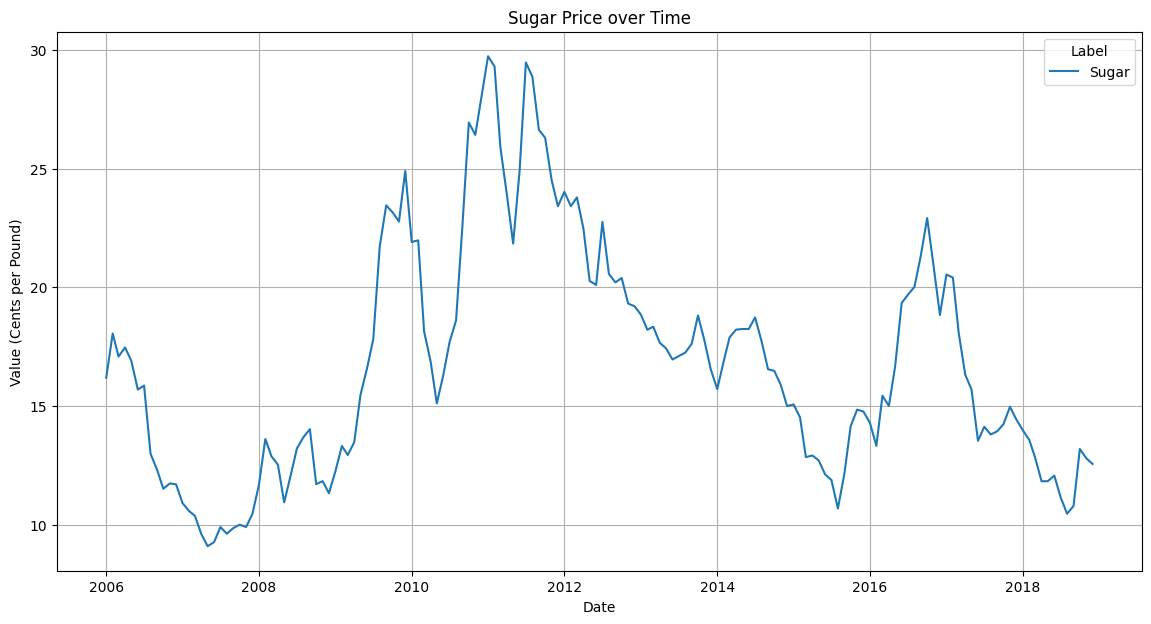

In [ ]:

import matplotlib.pyplot as plt

# Create a plot for each label
plt.figure(figsize=(14, 7))

plt.plot(commodity_path_df['Date-Time'], commodity_path_df['Value'], label=label)

plt.title('Sugar Price over Time')
plt.xlabel('Date')
plt.ylabel('Value (Cents per Pound)')
plt.legend(title='Label')
plt.grid(True)
plt.show()

In [ ]:
# Set 'Date-Time' as the index
commodity_path_df.set_index('Date-Time', inplace=True)

# Resample data by year, aggregating values (e.g., mean)
annual_data = commodity_path_df['Value'].resample('Y').mean()
annual_data.head()

,Value
Date-Time,
2006-12-31,14.788470
2007-12-31,9.956637
2008-12-31,12.452207
2009-12-31,18.150361
2010-12-31,20.890925


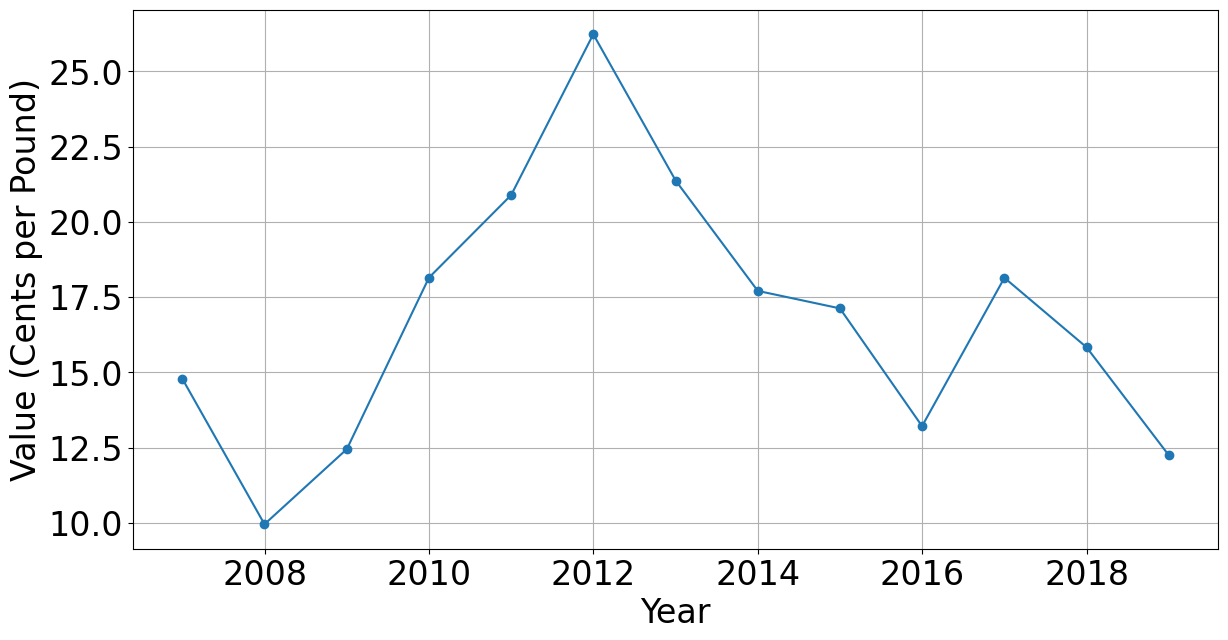

In [ ]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(annual_data.index, annual_data, label='Annual Average', marker='o')

plt.xlabel('Year', fontsize=24)
plt.ylabel('Value (Cents per Pound)', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.show()

# Health Data

In [ ]:
obesity_path = "/content/drive/MyDrive/Research @ CMU/Citadel Datathon/Datathon Data/Nutrition_Physical_Activity_and_Obesity_Data.csv"
# Reading the file
with open(obesity_path, 'r') as file:
    content = file.read()

In [ ]:
health_df = pd.read_csv(obesity_path,  parse_dates=['YearStart'])
health_df.sort_values(by='YearStart', inplace=True)

<ipython-input-2452-d677bae40221>:1: DtypeWarning: Columns (18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  health_df = pd.read_csv(obesity_path,  parse_dates=['YearStart'])


## Obesity

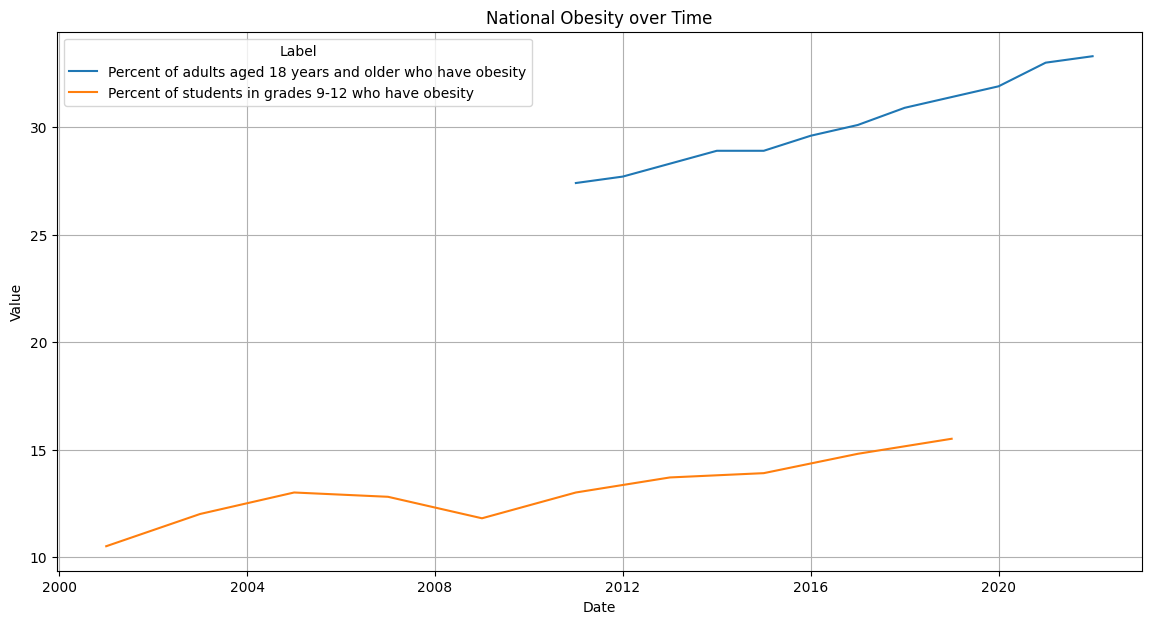

In [ ]:
obesity_df = health_df[((health_df["Question"] == "Percent of adults aged 18 years and older who have obesity") |
                       (health_df["Question"] == "Percent of students in grades 9-12 who have obesity")) &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

grouped = obesity_df.groupby("Question")

# Create a plot for each label
plt.figure(figsize=(14, 7))

for label, group in grouped:
    plt.plot(group['YearStart'], group['Data_Value'], label=label)

plt.title('National Obesity over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Label')
plt.grid(True)
plt.show()

In [ ]:
adult_obesity_df = health_df[(health_df["Question"] == "Percent of adults aged 18 years and older who have obesity") &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

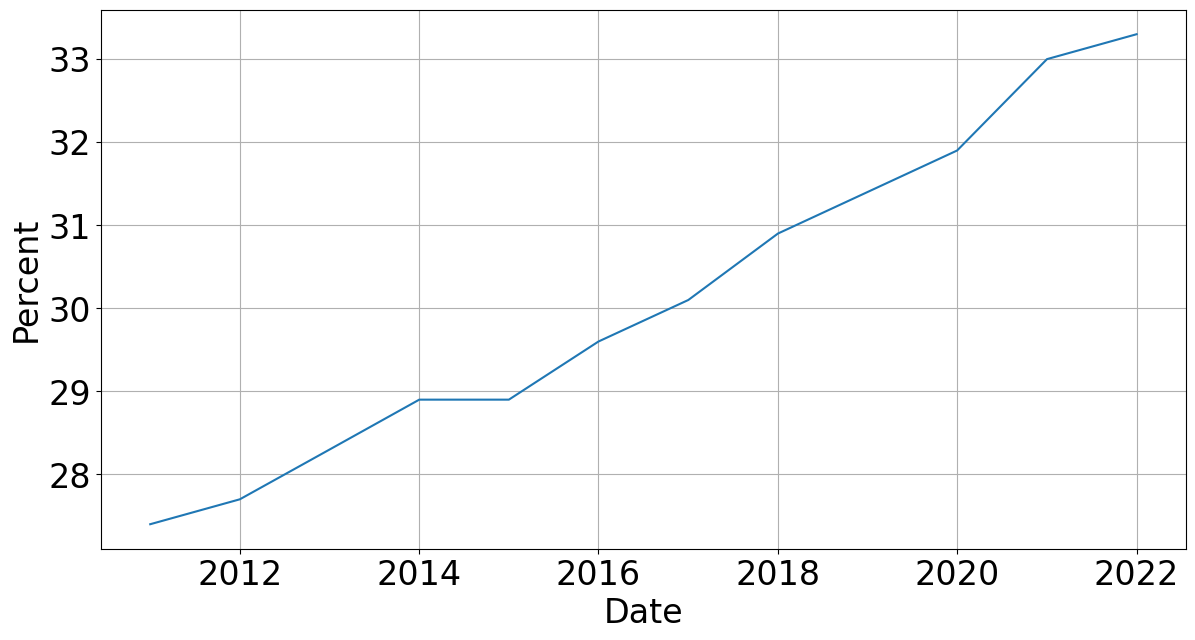

In [ ]:
# Create a plot for each label
plt.figure(figsize=(14, 7))

plt.plot(adult_obesity_df['YearStart'], adult_obesity_df['Data_Value'], label=label)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Percent', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.show()

In [ ]:
child_obesity_df = health_df[(health_df["Question"] == "Percent of students in grades 9-12 who have obesity") &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

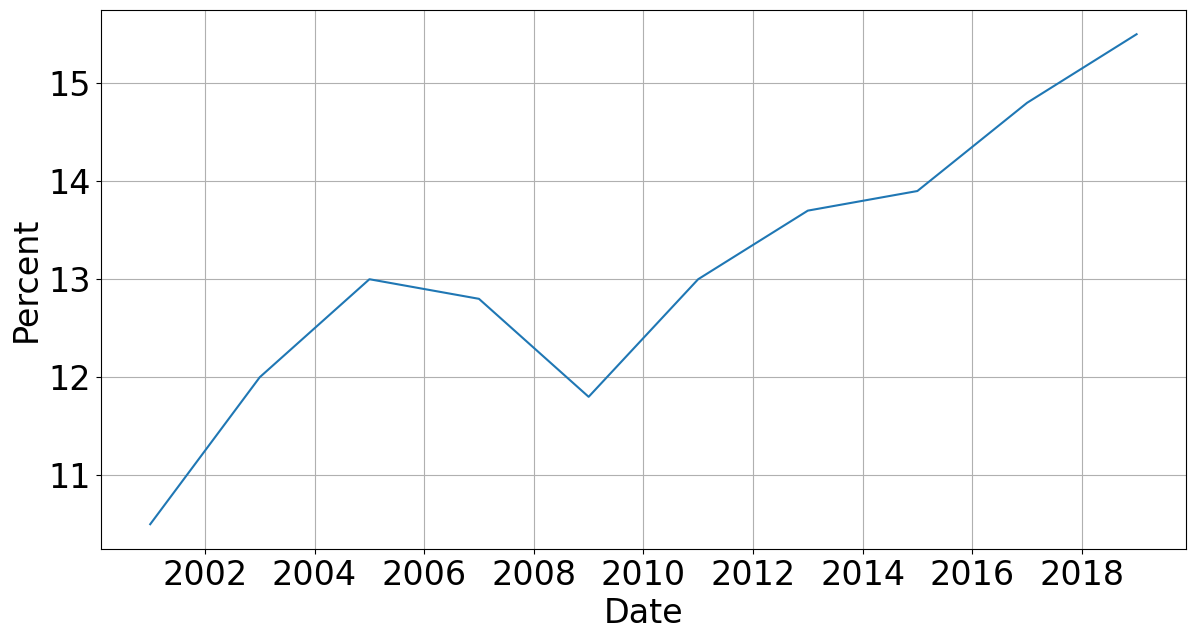

In [ ]:
# Create a plot for each label
plt.figure(figsize=(14, 7))

plt.plot(child_obesity_df['YearStart'], child_obesity_df['Data_Value'], label=label)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Percent', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.show()

## Adult Obesity with Broiler Correlation

In [ ]:
adult_obesity_df = health_df[(health_df["Question"] == "Percent of adults aged 18 years and older who have obesity") &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

In [ ]:
new_broiler_df = meat_df[(meat_df['Animal'] == 'Broilers') & (meat_df['Date'] >= '2011-01-01')]

In [ ]:
combined_adult_df = pd.merge(adult_obesity_df, new_broiler_df, left_on='YearStart', right_on='Date', how='inner')

In [ ]:
combined_adult_df['Production'] = combined_adult_df['Production'].str.replace(',', '').astype(float)

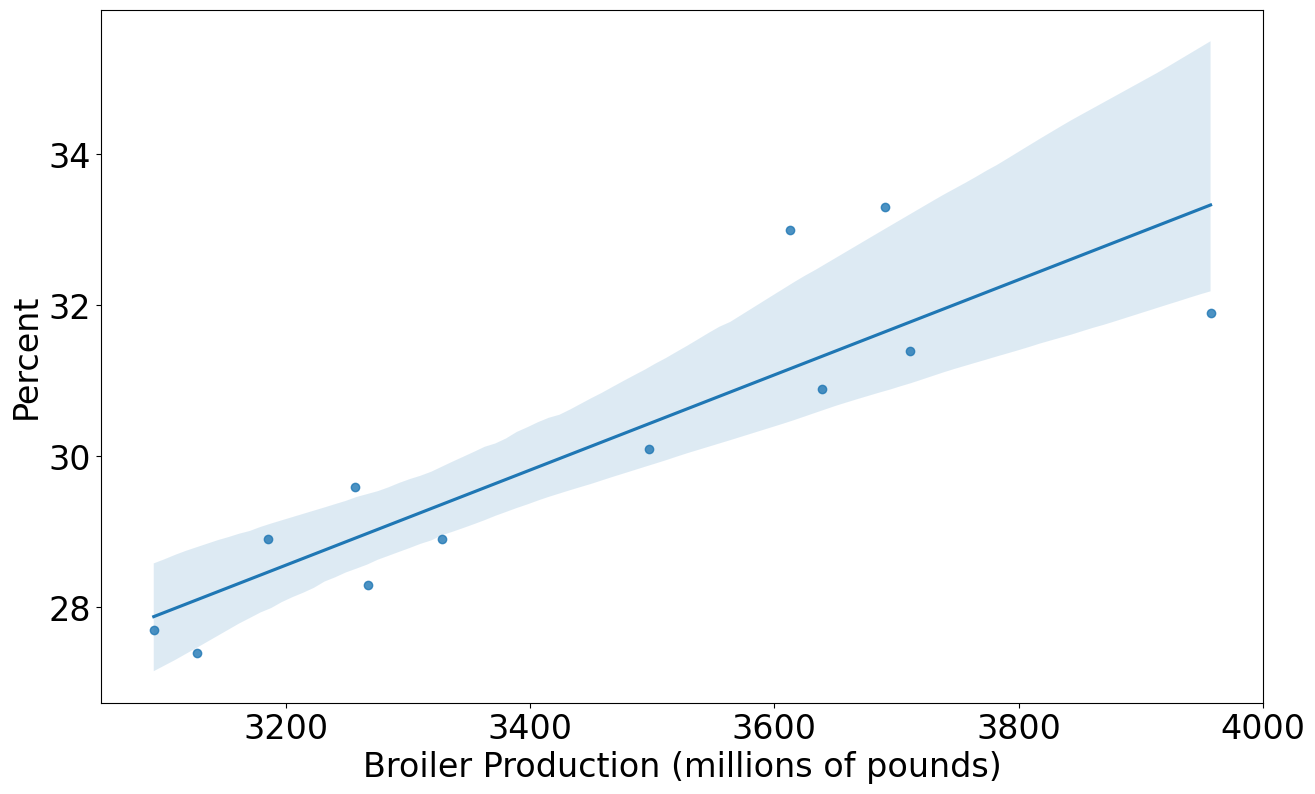

In [ ]:
# Create scatter plot with regression line
plt.figure(figsize=(15, 9))
sns.regplot(x='Production', y='Data_Value', data=combined_adult_df)
plt.xlabel('Broiler Production (millions of pounds)', fontsize=24)
plt.ylabel('Percent', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.show()

In [ ]:
from scipy.stats import linregress
# Extract data
x = combined_adult_df['Data_Value']
y = combined_adult_df['Production']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(y, x)

# Print the equation of the best-fit line
print(f"Best-fit line equation: y = {slope:.5f}x + {intercept:.5f}")

Best-fit line equation: y = 0.00630x + 8.39409


In [ ]:
# Calculate Pearson correlation between 'ObesityRate' and 'BroilerProduction'
correlation = combined_adult_df['Data_Value'].corr(combined_adult_df['Production'])

# Print the correlation matrix
print(correlation)

0.8720948861515067


## Child Obesity with Broiler Correlation

In [ ]:
child_obesity_df = health_df[(health_df["Question"] == "Percent of students in grades 9-12 who have obesity") &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

In [ ]:
combined_child_df = pd.merge(child_obesity_df, new_broiler_df, left_on='YearStart', right_on='Date', how='inner')

In [ ]:
combined_child_df['Production'] = combined_child_df['Production'].str.replace(',', '').astype(float)

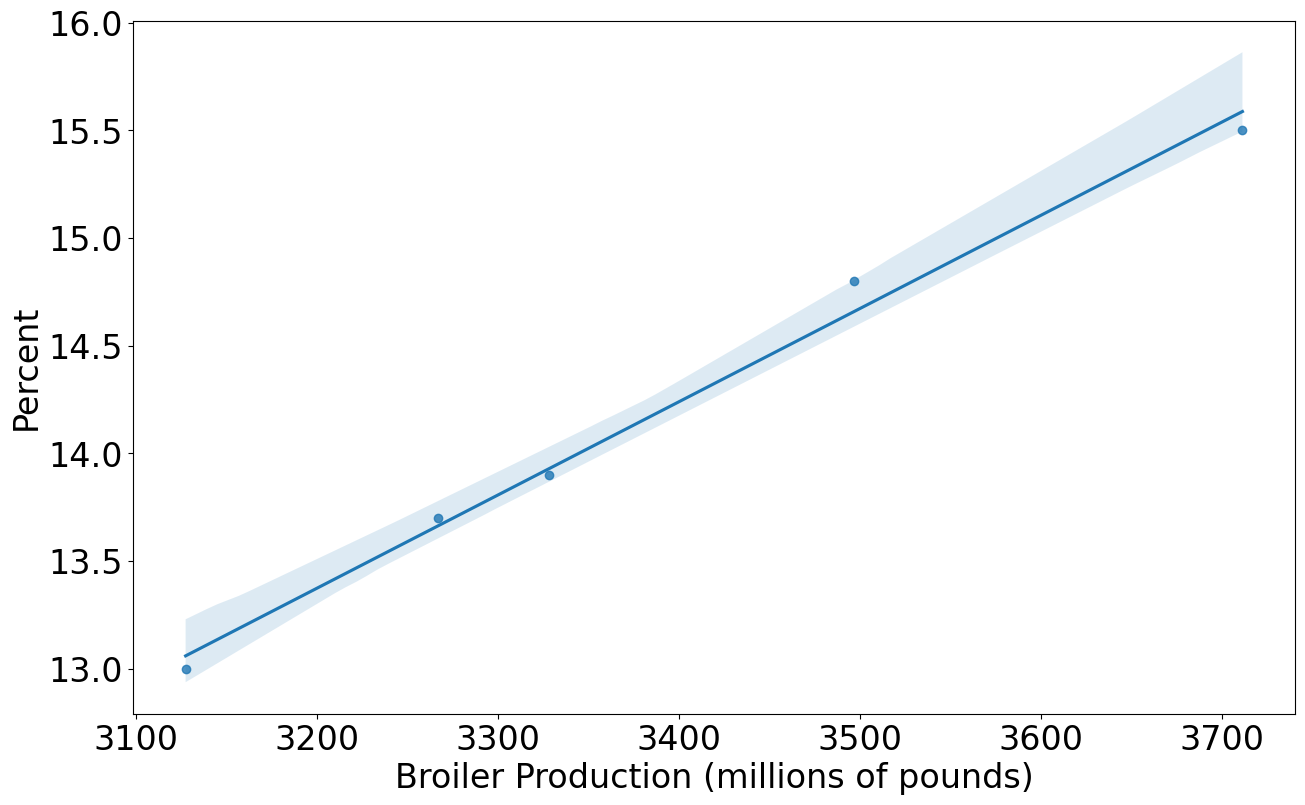

In [ ]:
# Create scatter plot with regression line
plt.figure(figsize=(15, 9))
sns.regplot(x='Production', y='Data_Value', data=combined_child_df)
plt.xlabel('Broiler Production (millions of pounds)', fontsize=24)
plt.ylabel('Percent', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.show()

In [ ]:
# Extract data
x = combined_child_df['Data_Value']
y = combined_child_df['Production']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(y, x)

# Print the equation of the best-fit line with more decimal places
print(f"Best-fit line equation: y = {slope:.5f}x + {intercept:.5f}")

Best-fit line equation: y = 0.00433x + -0.48121


In [ ]:
# Calculate Pearson correlation between 'ObesityRate' and 'BroilerProduction'
correlation = combined_adult_df['Data_Value'].corr(combined_child_df['Production'])

# Print the correlation matrix
print(correlation)

0.9190609157185337


## Overweight

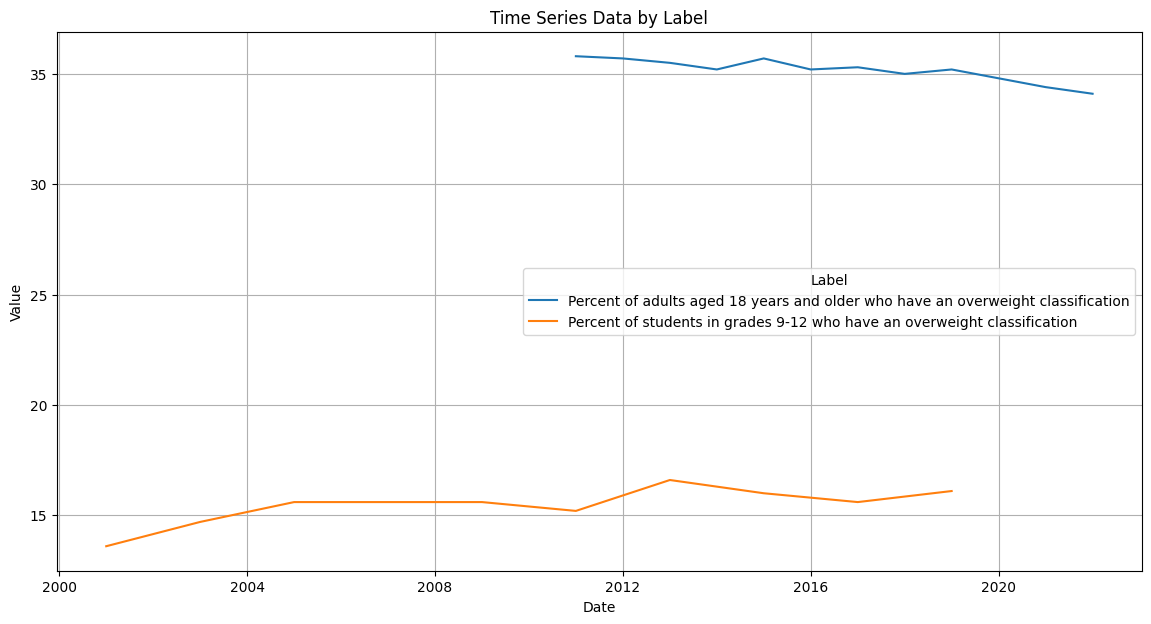

In [ ]:
overweight_df = health_df[((health_df["Question"] == "Percent of adults aged 18 years and older who have an overweight classification") |
                       (health_df["Question"] == "Percent of students in grades 9-12 who have an overweight classification")) &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

grouped = overweight_df.groupby("Question")

# Create a plot for each label
plt.figure(figsize=(14, 7))

for label, group in grouped:
    plt.plot(group['YearStart'], group['Data_Value'], label=label)

plt.title('Time Series Data by Label')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Label')
plt.grid(True)
plt.show()

## Sugar Drinks

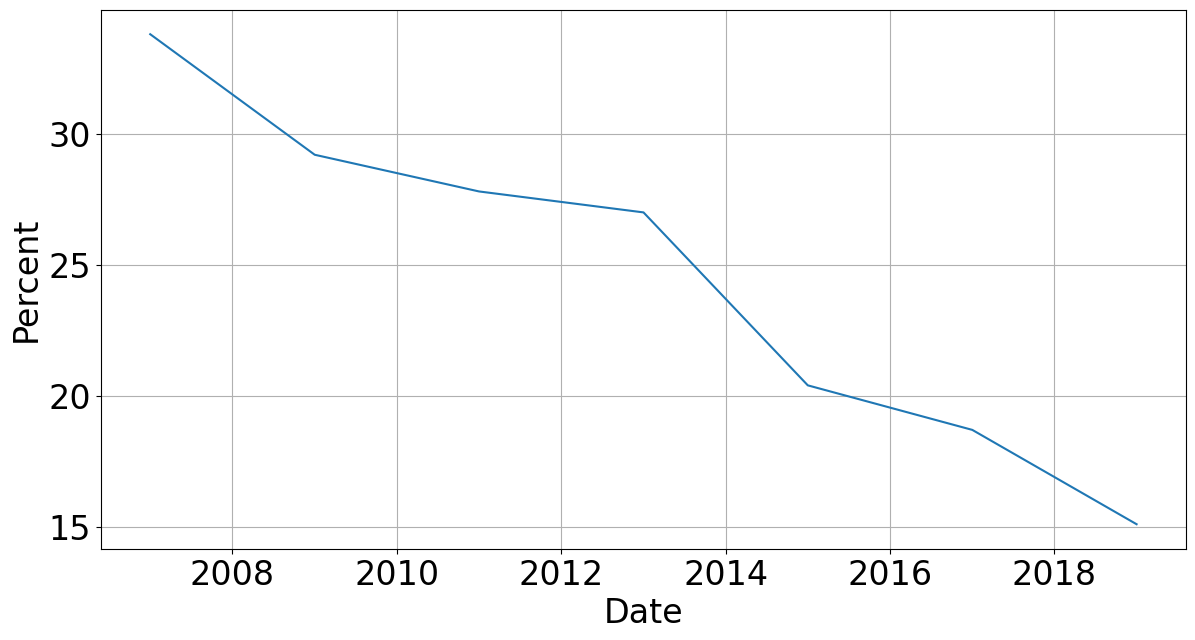

In [ ]:
sugar_df = health_df[(health_df["Question"] == "Percent of students in grades 9-12 who drank regular soda/pop at least one time per day") &
                      (health_df["Topic"] == "Sugar Drinks - Behavior") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

grouped = sugar_df.groupby("Question")

# Create a plot for each label
plt.figure(figsize=(14, 7))

for label, group in grouped:
    plt.plot(group['YearStart'], group['Data_Value'], label=label)

plt.xlabel('Date', fontsize=24)
plt.ylabel('Percent', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.show()

In [ ]:
sugar_obesity_df = health_df[((health_df["Question"] == "Percent of students in grades 9-12 who drank regular soda/pop at least one time per day") |
                      (health_df["Question"] == "Percent of students in grades 9-12 who have obesity")) &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

pivot_df = sugar_obesity_df.pivot(index='YearStart', columns='Question', values='Data_Value')

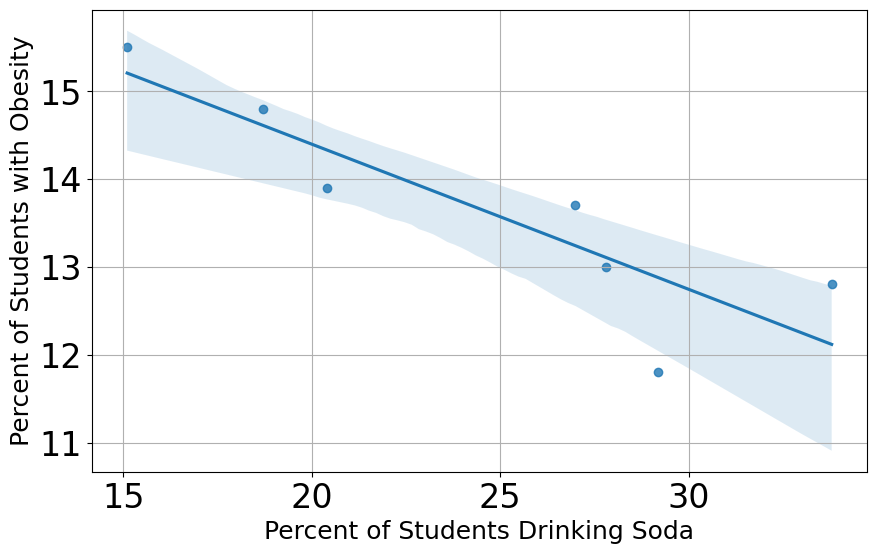

In [ ]:
# Reset the index to make 'YearStart' a column
pivot_df = pivot_df.reset_index()

# Rename columns for easier reference
pivot_df.columns = ['YearStart', 'Percent_Soda', 'Percent_Obesity']

# Drop rows with missing values
pivot_df = pivot_df.dropna()

# Create scatter plot and fit a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Percent_Soda', y='Percent_Obesity', data=pivot_df)
plt.xlabel('Percent of Students Drinking Soda', fontsize=18)
plt.ylabel('Percent of Students with Obesity', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.show()

In [ ]:
# Extract data
x = pivot_df['Percent_Soda']
y = pivot_df['Percent_Obesity']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(y, x)

# Print the equation of the best-fit line with more decimal places
print(f"Best-fit line equation: y = {slope:.5f}x + {intercept:.5f}")

Best-fit line equation: y = -4.66042x + 88.15288


In [ ]:
# Calculate Pearson correlation matrix
correlation_matrix = pivot_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                 YearStart  Percent_Soda  Percent_Obesity
YearStart         1.000000     -0.981896         0.925688
Percent_Soda     -0.981896      1.000000        -0.877510
Percent_Obesity   0.925688     -0.877510         1.000000


In [ ]:
sugar_cost_df = pd.merge(sugar_df, commodity_path_df, left_on='YearStart', right_on='Date-Time', how='inner')

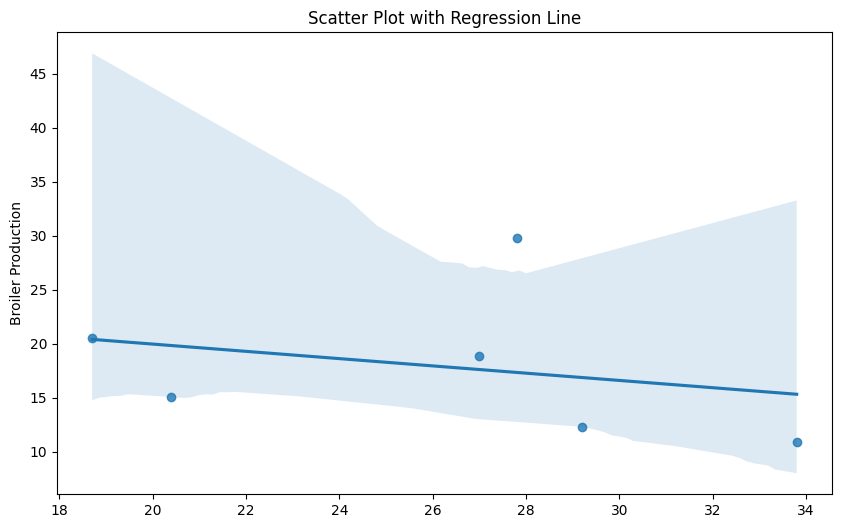

In [ ]:
# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Data_Value', y='Value', data=sugar_cost_df)
plt.title('Scatter Plot with Regression Line')
plt.xlabel('')
plt.ylabel('Broiler Production')
plt.show()

In [ ]:
correlation = sugar_cost_df['Data_Value'].corr(sugar_cost_df['Value'])

# Print the correlation matrix
print(correlation)

-0.2763107291365566


# Obesity and Healthcare

In [ ]:
obesity_df = health_df[((health_df["Question"] == "Percent of adults aged 18 years and older who have obesity") |
                       (health_df["Question"] == "Percent of students in grades 9-12 who have obesity")) &
                      (health_df["Topic"] == "Obesity / Weight Status") &
                      (health_df["StratificationID1"] == "OVERALL") &
                      (health_df["LocationAbbr"] == "US")]

## Loading Time Series Data on Pharma

In [ ]:
!pip -q install yfinance

In [ ]:
import yfinance as yf

In [ ]:
drug_manufacturers = ["LLY", "ABBV", "MRK", "AMGN", "JNJ", "PFE", "BMY", "GILD"]
healthcare_planners = ["UNH", "ELV", "CI", "CVS", "HUM", "CNC", "MOH"]
medical_instruments = ["ISRG", "RMD", "WST", "HOLX", "COO", "BAX", "TFX", "BDX", "ATR", "RGEN"]

In [ ]:
# Define the start and end dates
start_date = '2000-01-01'
end_date = '2022-12-31'

### Drug Manufacturers

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


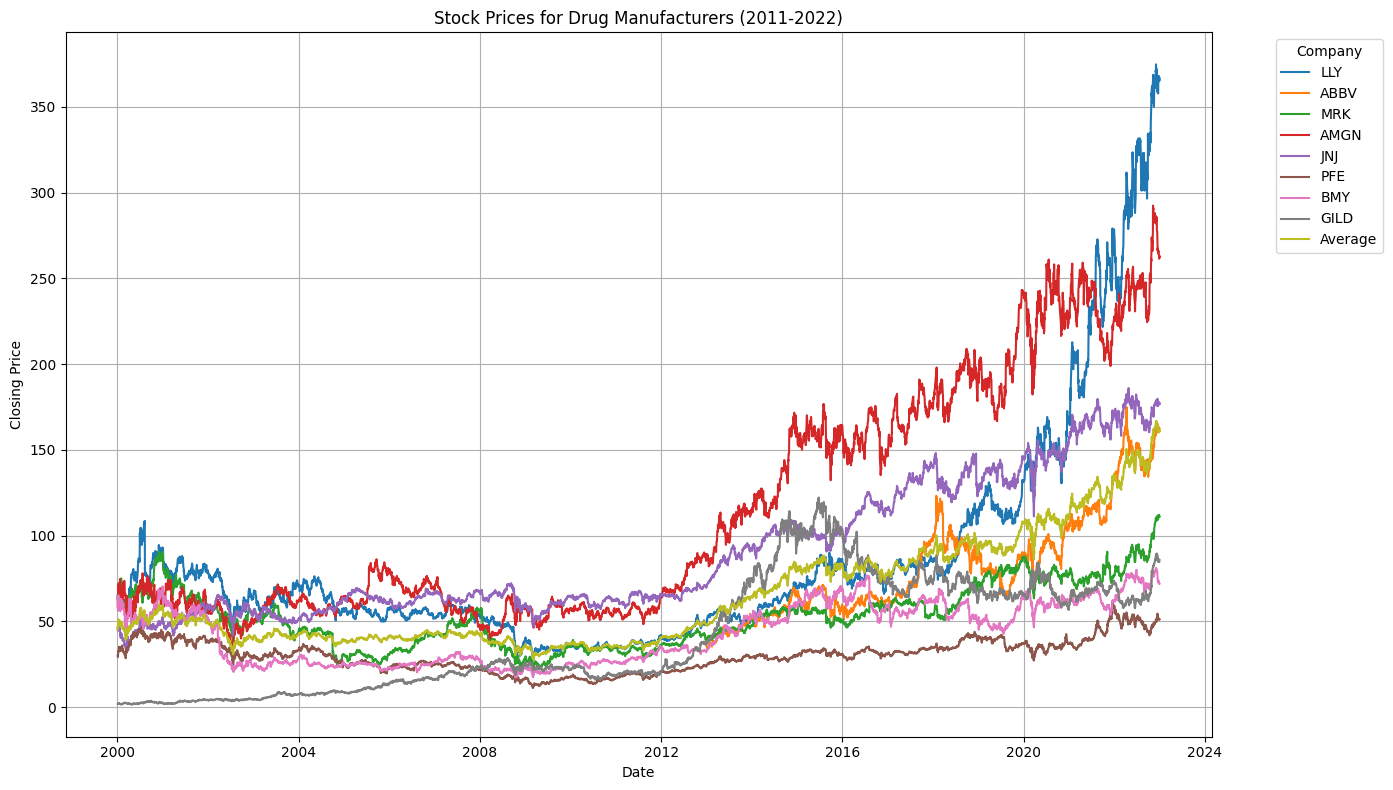

In [ ]:
# Initialize an empty DataFrame to hold all data
drug_manufacturers_data = pd.DataFrame()
# Load data for each ticker and append it to the all_data DataFrame
for ticker in drug_manufacturers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    drug_manufacturers_data = pd.concat([drug_manufacturers_data, df])

# Calculate the average closing price per day
avg_data = drug_manufacturers_data.groupby('Date')['Close'].mean().reset_index()
avg_data['Ticker'] = 'Average'

# Combine average data with the original data for plotting
combined_data = pd.concat([drug_manufacturers_data, avg_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_data, x='Date', y='Close', hue='Ticker', palette='tab10')
plt.title('Stock Prices for Drug Manufacturers (2011-2022)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


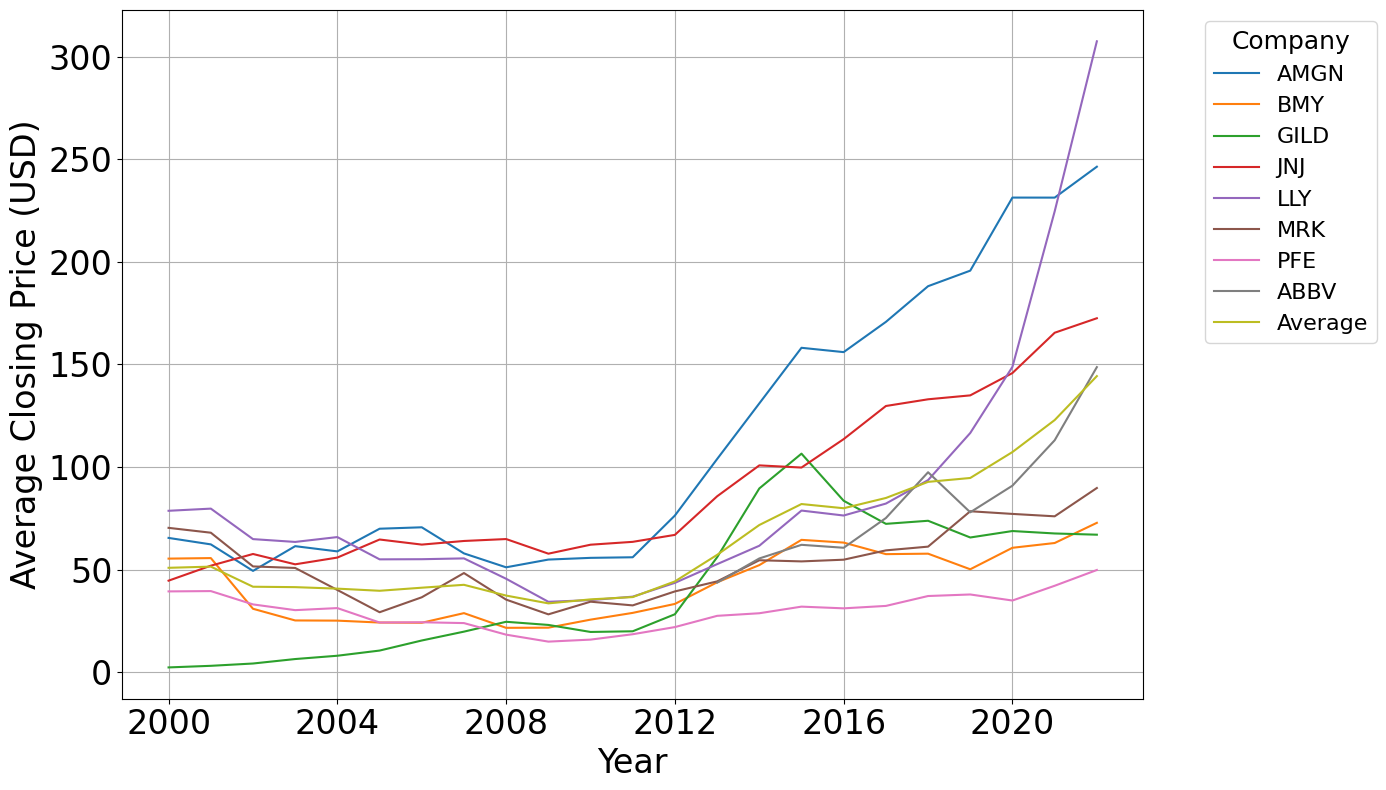

In [ ]:
# Initialize an empty DataFrame to hold all data
drug_manu_data = pd.DataFrame()

# Load data for each ticker and append it to the drug_manu_data DataFrame
for ticker in drug_manufacturers:
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    drug_manu_data = pd.concat([drug_manu_data, df])

# Ensure 'Date' column is in datetime format
drug_manu_data['Date'] = pd.to_datetime(drug_manu_data['Date'])

# Add a column for the year
drug_manu_data['Year'] = drug_manu_data['Date'].dt.to_period('Y')

# Calculate the average closing price per year for each ticker
yearly_avg_data = drug_manu_data.groupby(['Year', 'Ticker'])['Close'].mean().reset_index()

# Calculate the overall average closing price per year across all tickers
overall_avg_data = drug_manu_data.groupby('Year')['Close'].mean().reset_index()
overall_avg_data['Ticker'] = 'Average'

# Combine yearly average data with the overall average data for plotting
combined_yearly_drug_manu_data = pd.concat([yearly_avg_data, overall_avg_data], ignore_index=True)

# Convert 'Year' to datetime for plotting
combined_yearly_drug_manu_data['Year'] = combined_yearly_drug_manu_data['Year'].dt.to_timestamp()

# Calculate the cumulative average closing price per year across all tickers
#combined_yearly_drug_manu_data['Cumulative_Avg'] = combined_yearly_drug_manu_data.groupby('Year')['Close'].transform('mean')

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_yearly_drug_manu_data, x='Year', y='Close', hue='Ticker', palette='tab10')
# sns.lineplot(data=combined_yearly_drug_manu_data[combined_yearly_drug_manu_data['Ticker'] == 'Average'], x='Year', y='Cumulative_Avg', color='black', label='Cumulative Average', linewidth=2)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Closing Price (USD)', fontsize=24)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
combined_drug_manu_df = pd.merge(obesity_df, combined_yearly_drug_manu_data, left_on='YearStart', right_on='Year', how='inner')

In [ ]:
# Calculate Pearson correlation between 'ObesityRate' and 'BroilerProduction'
correlation = combined_drug_manu_df['Data_Value'].corr(combined_drug_manu_df['Close'])

# Print the correlation matrix
print(correlation)

0.6198384339119352


In [ ]:
combined_drug_manu_df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1,Year,Ticker,Close
0,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,Q038,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,AMGN,62.314216
1,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,Q038,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,BMY,55.637007
2,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,Q038,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,GILD,3.133974
3,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,Q038,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,JNJ,51.932243
4,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,Q038,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,LLY,79.742238


### Healthcare Planners

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


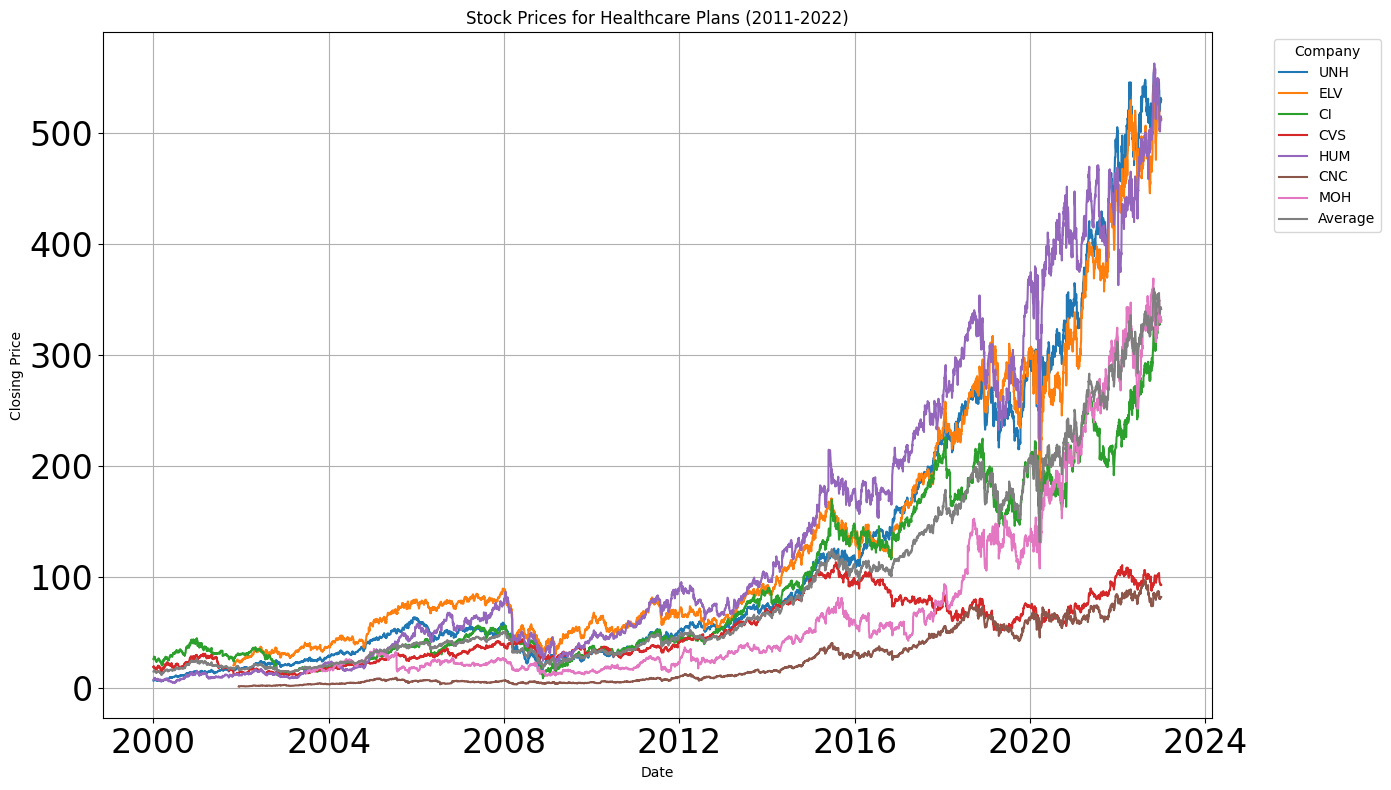

In [ ]:
# Initialize an empty DataFrame to hold all data
healthcare_planners_data = pd.DataFrame()
# Load data for each ticker and append it to the all_data DataFrame
for ticker in healthcare_planners:
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    healthcare_planners_data = pd.concat([healthcare_planners_data, df])

# Calculate the average closing price per day
avg_data = healthcare_planners_data.groupby('Date')['Close'].mean().reset_index()
avg_data['Ticker'] = 'Average'

# Combine average data with the original data for plotting
combined_data = pd.concat([healthcare_planners_data, avg_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_data, x='Date', y='Close', hue='Ticker', palette='tab10')
plt.title('Stock Prices for Healthcare Plans (2011-2022)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


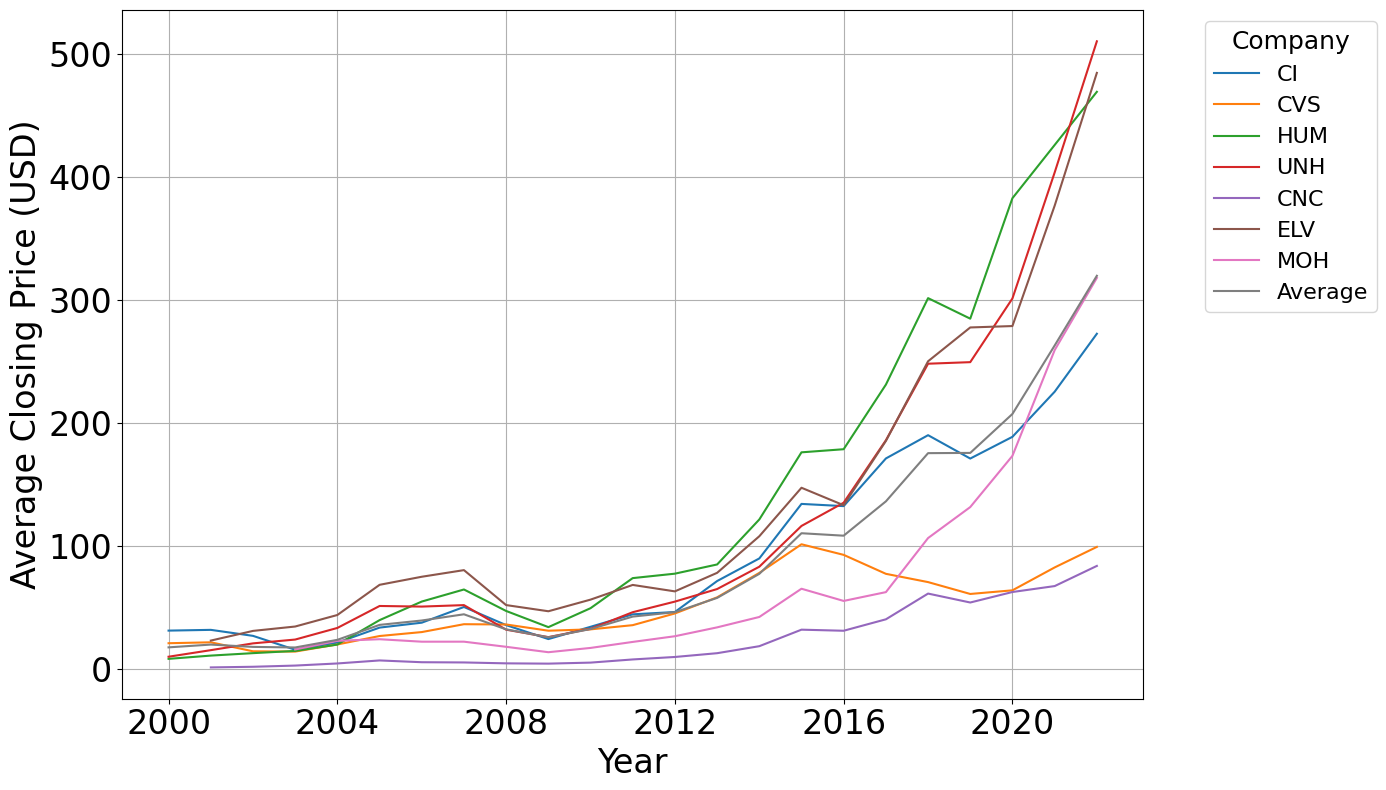

In [ ]:
# Initialize an empty DataFrame to hold all data
healthcare_plan_data = pd.DataFrame()

# Load data for each ticker and append it to the drug_manu_data DataFrame
for ticker in healthcare_planners:
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    healthcare_plan_data = pd.concat([healthcare_plan_data, df])

# Ensure 'Date' column is in datetime format
healthcare_plan_data['Date'] = pd.to_datetime(healthcare_plan_data['Date'])

# Add a column for the year
healthcare_plan_data['Year'] = healthcare_plan_data['Date'].dt.to_period('Y')

# Calculate the average closing price per year for each ticker
yearly_avg_data = healthcare_plan_data.groupby(['Year', 'Ticker'])['Close'].mean().reset_index()

# Calculate the overall average closing price per year across all tickers
overall_avg_data = healthcare_plan_data.groupby('Year')['Close'].mean().reset_index()
overall_avg_data['Ticker'] = 'Average'

# Combine yearly average data with the overall average data for plotting
combined_yearly_healthcare_plan_data = pd.concat([yearly_avg_data, overall_avg_data], ignore_index=True)

# Convert 'Year' to datetime for plotting
combined_yearly_healthcare_plan_data['Year'] = combined_yearly_healthcare_plan_data['Year'].dt.to_timestamp()

# Calculate the cumulative average closing price per year across all tickers
combined_yearly_healthcare_plan_data['Cumulative_Avg'] = combined_yearly_healthcare_plan_data.groupby('Year')['Close'].transform('mean')

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_yearly_healthcare_plan_data, x='Year', y='Close', hue='Ticker', palette='tab10')
# sns.lineplot(data=combined_yearly_healthcare_plan_data[combined_yearly_healthcare_plan_data['Ticker'] == 'Average'], x='Year', y='Cumulative_Avg', color='black', label='Cumulative Average', linewidth=2)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Closing Price (USD)', fontsize=24)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
combined_health_plan_df = pd.merge(obesity_df, combined_yearly_healthcare_plan_data, left_on='YearStart', right_on='Year', how='inner')

In [ ]:
# Calculate Pearson correlation between 'ObesityRate' and 'BroilerProduction'
correlation = combined_health_plan_df['Data_Value'].corr(combined_health_plan_df['Close'])

# Print the correlation matrix
print(correlation)

0.5108216378057722


In [ ]:
combined_health_plan_df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1,Year,Ticker,Close,Cumulative_Avg
0,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,CI,32.126707,18.031669
1,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,CNC,1.618889,18.031669
2,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,CVS,22.014274,18.031669
3,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,ELV,23.423256,18.031669
4,2001-01-01,2001,US,National,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,VALUE,59,Total,Total,OVR,OVERALL,2001-01-01,HUM,11.225111,18.031669


### Medical Instruments

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


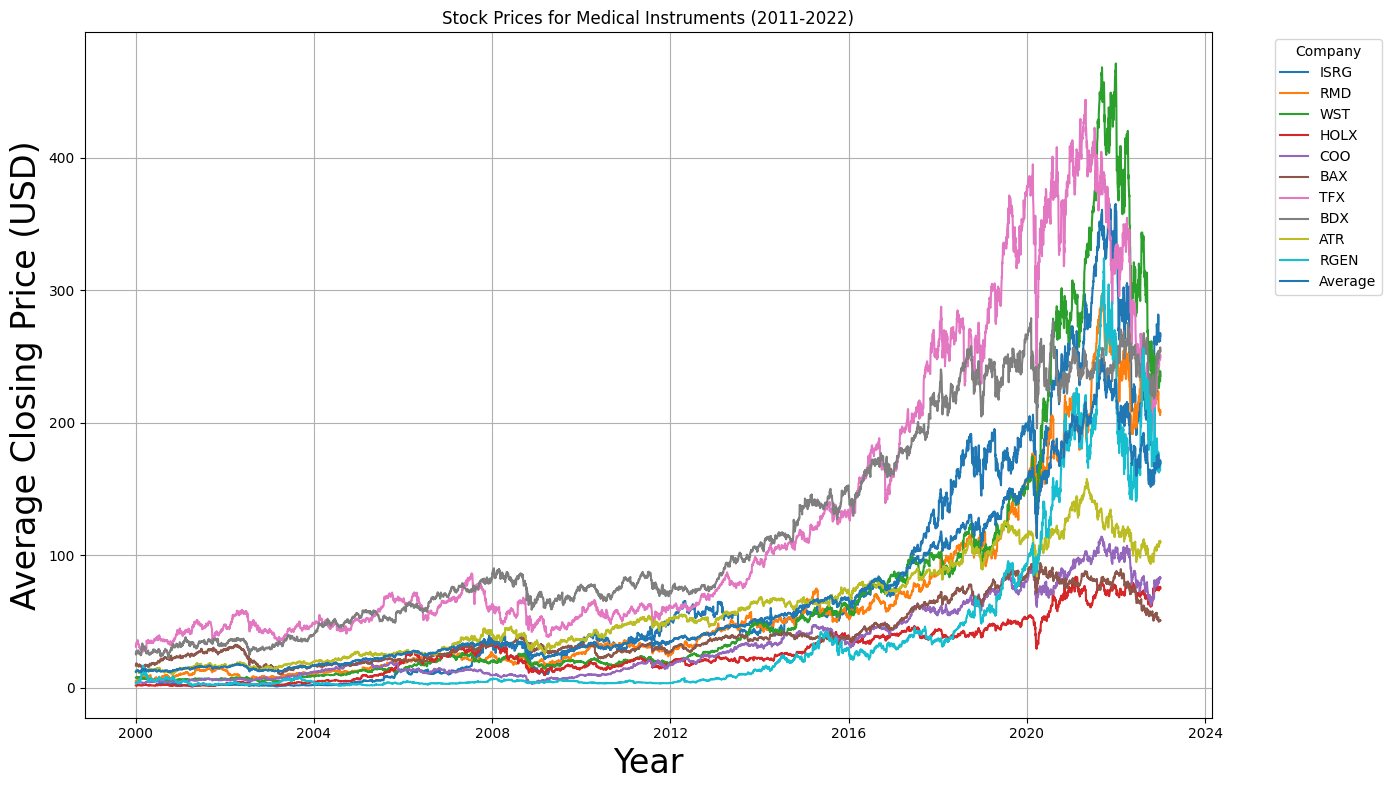

In [ ]:
# Initialize an empty DataFrame to hold all data
medical_instruments_data = pd.DataFrame()
# Load data for each ticker and append it to the all_data DataFrame
for ticker in medical_instruments:
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    medical_instruments_data = pd.concat([medical_instruments_data, df])

# Calculate the average closing price per day
avg_data = medical_instruments_data.groupby('Date')['Close'].mean().reset_index()
avg_data['Ticker'] = 'Average'

# Combine average data with the original data for plotting
combined_data = pd.concat([medical_instruments_data, avg_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_data, x='Date', y='Close', hue='Ticker', palette='tab10')
plt.title('Stock Prices for Medical Instruments (2011-2022)')
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Closing Price (USD)', fontsize=24)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


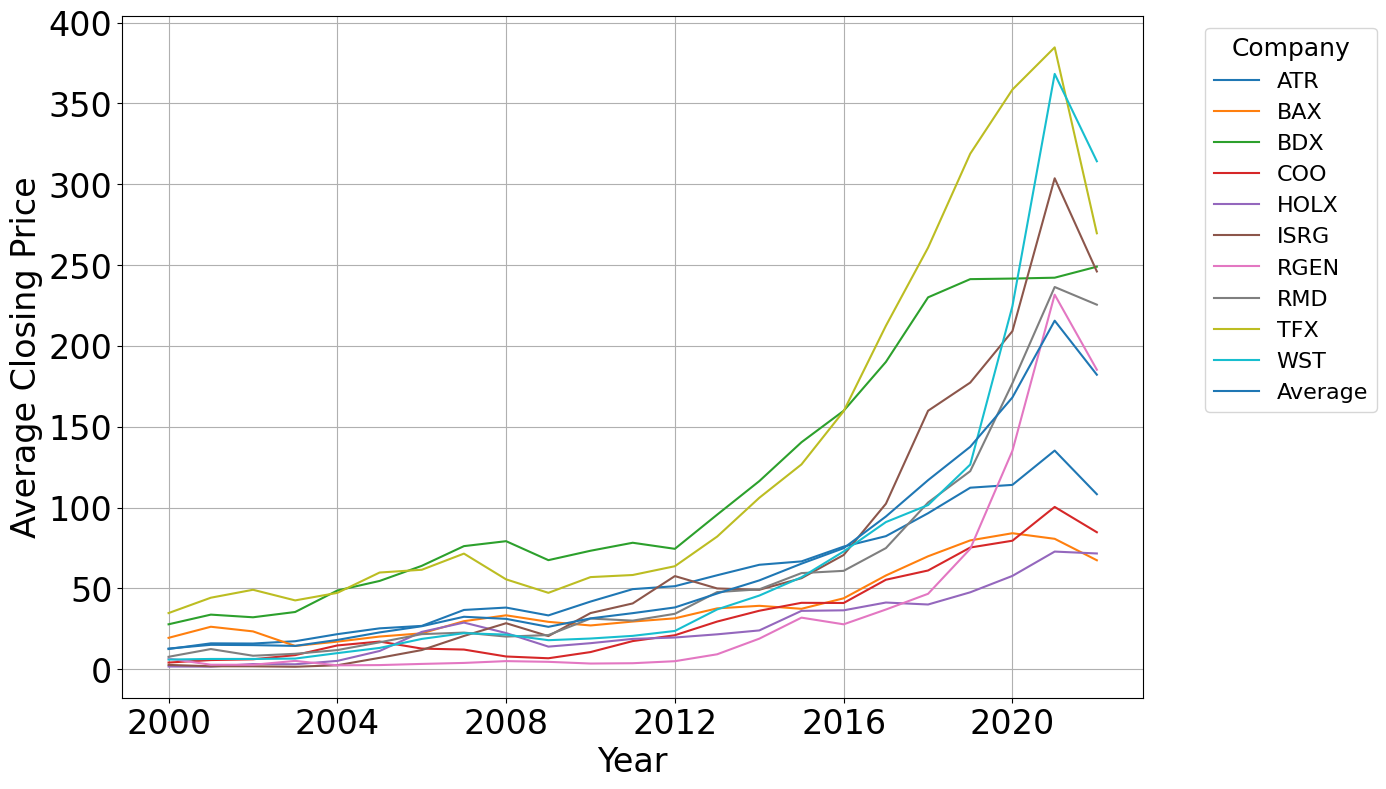

In [ ]:
# Initialize an empty DataFrame to hold all data
med_inst_data = pd.DataFrame()

# Load data for each ticker and append it to the drug_manu_data DataFrame
for ticker in medical_instruments:
    # Fetch data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df['Ticker'] = ticker
    df.reset_index(inplace=True)
    med_inst_data = pd.concat([med_inst_data, df])

# Ensure 'Date' column is in datetime format
med_inst_data['Date'] = pd.to_datetime(med_inst_data['Date'])

# Add a column for the year
med_inst_data['Year'] = med_inst_data['Date'].dt.to_period('Y')

# Calculate the average closing price per year for each ticker
yearly_avg_data = med_inst_data.groupby(['Year', 'Ticker'])['Close'].mean().reset_index()

# Calculate the overall average closing price per year across all tickers
overall_avg_data = med_inst_data.groupby('Year')['Close'].mean().reset_index()
overall_avg_data['Ticker'] = 'Average'

# Combine yearly average data with the overall average data for plotting
combined_yearly_medical_plan_inst = pd.concat([yearly_avg_data, overall_avg_data], ignore_index=True)

# Convert 'Year' to datetime for plotting
combined_yearly_medical_plan_inst['Year'] = combined_yearly_medical_plan_inst['Year'].dt.to_timestamp()

# Calculate the cumulative average closing price per year across all tickers
combined_yearly_medical_plan_inst['Cumulative_Avg'] = combined_yearly_medical_plan_inst.groupby('Year')['Close'].transform('mean')

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_yearly_medical_plan_inst, x='Year', y='Close', hue='Ticker', palette='tab10')
#sns.lineplot(data=combined_yearly_medical_plan_inst[combined_yearly_medical_plan_inst['Ticker'] == 'Average'], x='Year', y='Cumulative_Avg', color='black', label='Cumulative Average', linewidth=2)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Closing Price',fontsize=24)
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
combined_medical_instr_df = pd.merge(obesity_df, combined_yearly_medical_plan_inst, left_on='YearStart', right_on='Year', how='inner')

In [ ]:
# Calculate Pearson correlation between 'ObesityRate' and 'BroilerProduction'
correlation = combined_medical_instr_df['Data_Value'].corr(combined_medical_instr_df['Close'])

# Print the correlation matrix
print(correlation)

0.5336458856699469
